## Desafío entregable #11: Entrenando un algoritmo de Machine Learning

In [422]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point

En este desafío se trabajará con el dataset "California Housing", el cual resumen información inmobiliaria de dicho estado de los EE.UU. Dicha información esta agrupada en "block groups" (BG), el cual es la unidad geográfica más pequeña que el U.S. Census Bureau registra informacion. Otra agrupación presente en el dataset es "household" (HH), que es el número de personas residentes en una casa. Un block group típicamente vive entre 600 y 3000 personas. Las variables presentes en el dataset son:

- longitude: longitud del BG.
- latitude: latitud del BG.
- housing_median_age: mediana de la edad del BG.
- total_rooms: promedio de ambientes por HH. 
- total_bedrooms: promedio de habitaciones por HH.
- population: población del BG.
- households: número de HH por BG. 
- median_income: mediana del ingreso del BG.
- median_house_value: mediana del valor del HH.  
- ocean_proximity: cercanía al océano, variable categórica.
- gender: género mayoritario del BG.

El objetivo es predecir la mediana del valor de los inmuebles, expresados en cientos de miles de dólares (US$ 100.000). Para ello se realizará el procedimiento usual de análisis exploratorio, limpieza de datos, curación de datos y finalmente predicción de la variable objetivo por medio de algoritmos de regresión.

In [231]:
df = pd.read_csv('Housing_Price.csv')

## Análisis exploratorio de datos

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20382 non-null  float64
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      15758 non-null  float64
 5   population          20596 non-null  float64
 6   households          19335 non-null  object 
 7   median_income       17873 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
 10  gender              16620 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 1.7+ MB


In [233]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.0100,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20382.0,28.676283,12.589284,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.0000,39320.0000
total_bedrooms,15758.0,539.920104,419.834171,1.0000,296.0000,435.0000,652.0000,6210.0000
population,20596.0,1424.928724,1132.237768,3.0000,787.0000,1166.0000,1725.0000,35682.0000
median_income,17873.0,3.939403,1.943517,0.4999,2.5986,3.5871,4.8304,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.0000,500001.0000


In [234]:
df.describe(include = "object").T

,count,unique,top,freq
households,19335,1703,no,3080
ocean_proximity,20640,5,<1H OCEAN,9136
gender,16620,2,female,8673


El dataset posee ocho variables categóricas y tres variables categóricas. Sin embargo, "households", por definición, no debería ser categórica. Más adelante se analizará dicha variable.

Exploremos la distribución espacial del valor de las propiedades y su cercanía al océano:

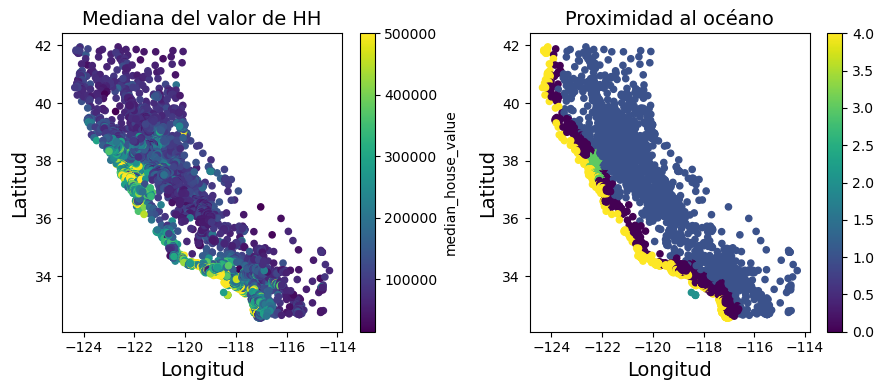

In [235]:
ocean_codes = pd.Categorical(df['ocean_proximity']).codes

fig, axs = plt.subplots(1, 2, figsize=(9,4))
df.plot(x="longitude", y="latitude", c ="median_house_value", kind="scatter", colormap="viridis", ax=axs[0])
df.plot(x="longitude", y="latitude", c=ocean_codes, kind="scatter", colormap="viridis", ax=axs[1])

axs[0].set_xlabel('Longitud', fontsize = 14)
axs[0].set_ylabel('Latitud', fontsize = 14)
axs[0].set_title('Mediana del valor de HH', fontsize = 14)

axs[1].set_xlabel('Longitud', fontsize = 14)
axs[1].set_ylabel('Latitud', fontsize = 14)
axs[1].set_title('Proximidad al océano', fontsize = 14)

plt.tight_layout()
plt.show()

A simple vista parece que el valor aumenta conforme con la cercanía a la costa, sin embargo los inmubles al norte del estado desafían dicha conclusión. Además se observan que valores altos (> $ 400.000) tienen a agruparse en diferentes puntos de la costa, que posiblemente coincidan con núcleos urbanos. En el gráfico de la derecha se obserba la distribución de la variable categórica "ocean_proximity", que busca dar cierta idea de la cercanía al mar.

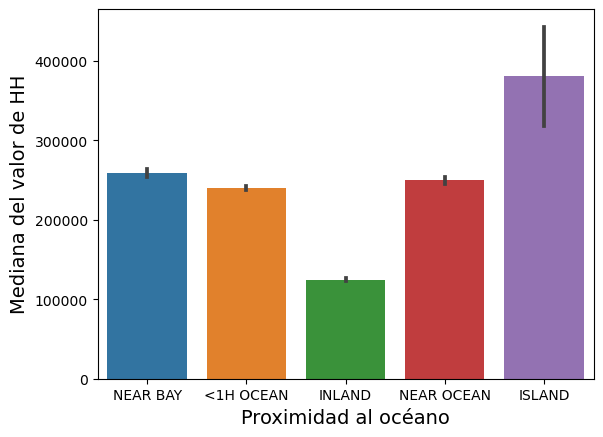

In [236]:
sns.barplot(data=df, x="ocean_proximity",y="median_house_value")
plt.xlabel('Proximidad al océano', fontsize = 14)
plt.ylabel('Mediana del valor de HH', fontsize = 14)
plt.show()

Los inmuebles ubicados en la isla son los más valiosos, mientras que las propiedades tierra dentro valen casi un tercio de los anteriores. Inmuebles con cierta cercanía al mar poseen valores intermedios. Claramente existe una correlación entre estas dos variables.

In [237]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

La variable "ocean_proximity" clasifica la distancia al océano en variables categóricas ambiguas. ¿Qué es cerca del óceano? ¿Cómo se define "menos de una hora"? Es por ello que se buscarán obtener variables más informativas.

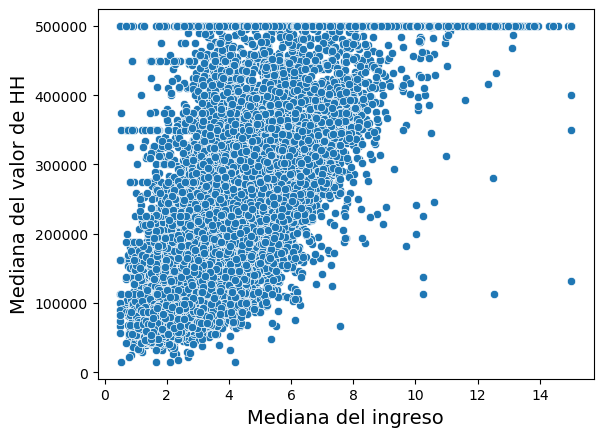

In [238]:
sns.scatterplot(data = df, x = "median_income", y = "median_house_value")
plt.xlabel('Mediana del ingreso', fontsize = 14)
plt.ylabel('Mediana del valor de HH', fontsize = 14)
plt.show()

Se nota una clara correlación entre estas dos variables: a mayor ingreso, mayor valor de la propiedad. Desafortunadamente los valores de "median_house_value" mayores a 500.000 se encuentran todos colapsados a este valor. 

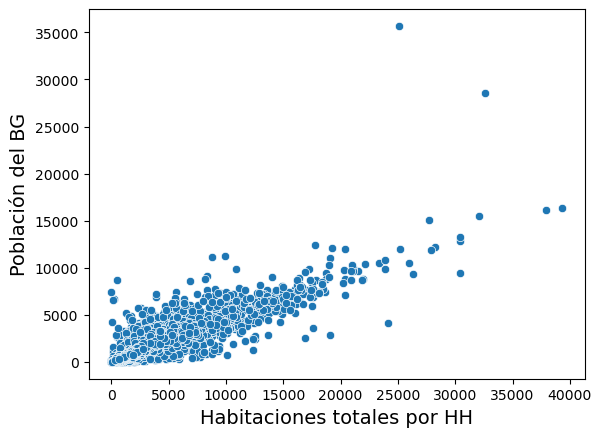

In [239]:
sns.scatterplot(data = df, x = "total_rooms", y = "population")
plt.xlabel('Habitaciones totales por HH', fontsize = 14)
plt.ylabel('Población del BG', fontsize = 14)
plt.show()

Otra correlación interesante se encuentra entre las variables número de habitaciones y población. Esta correlación es considerable, e indica que a mayor población, mayor número de habitaciones. 

Existen numerosas correlaciones importantes entre las variables, no exploraremos todas pero si las graficaremos y calcularemos dichas correlaciones.

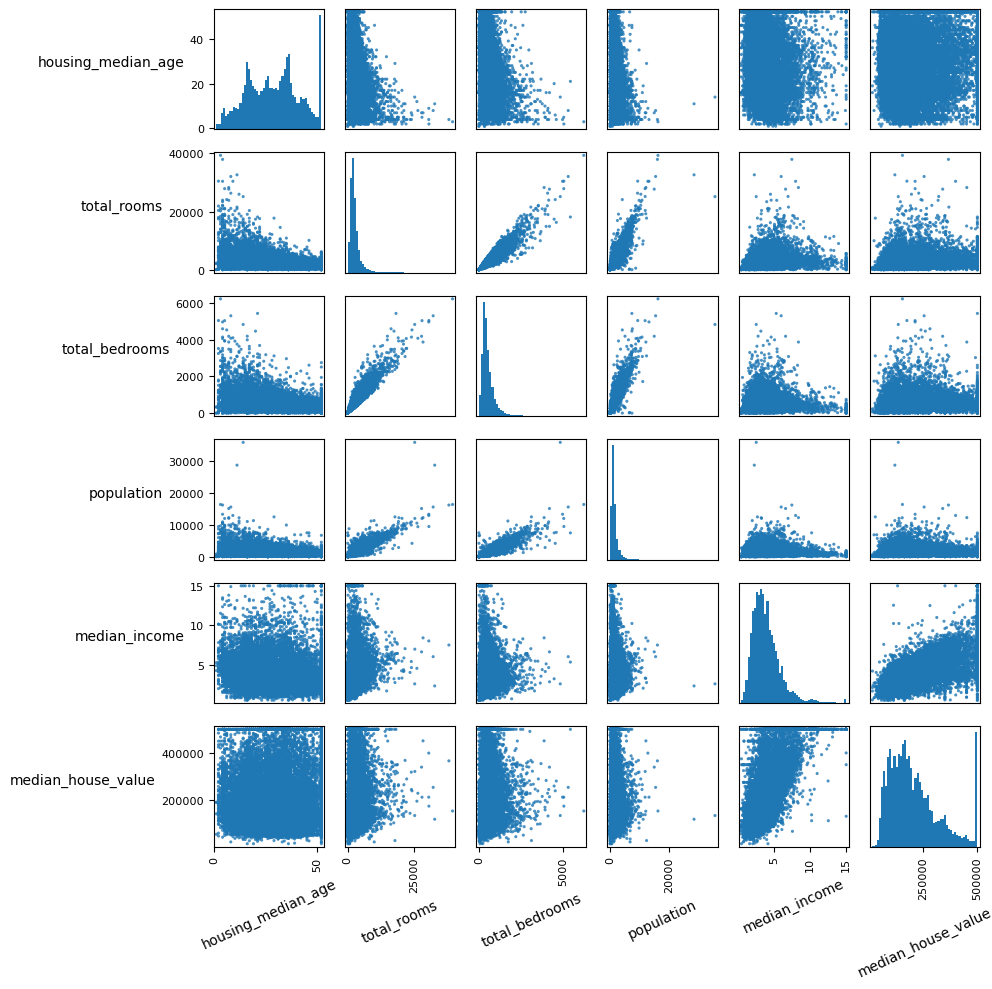

In [240]:
axes = pd.plotting.scatter_matrix(df.iloc[:,2:-1], figsize=(10,10), marker='.', hist_kwds={'bins': 50}, s=20, alpha =.8)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(25)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.show()

Además de las correlaciones, observamos que en todas las variables, excepto "housing_median_age" la distribución de los datos no es normal, la distribución es similar a una Poisson. Esto es relevante a la hora de determinar si efectuar un proceso de estandarización.

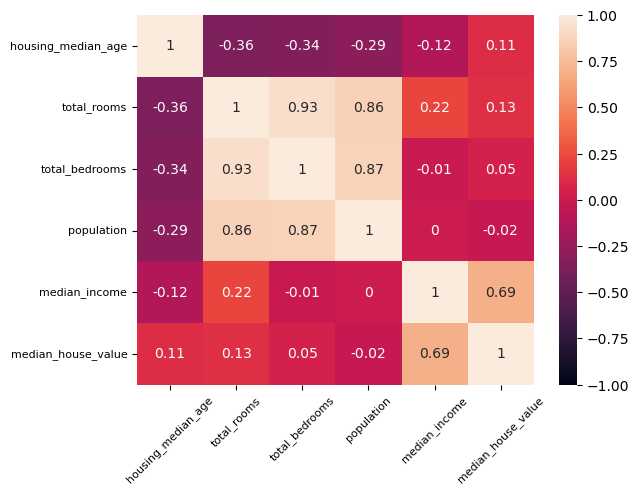

In [241]:
sns.heatmap(df.iloc[:,2:-1].corr(numeric_only = True).round(2), vmin=-1, vmax=1, cbar = True, annot=True)
plt.xticks(fontsize = 8, rotation=45) 
plt.yticks(fontsize = 8) 
plt.show()

Con respecto a las correlaciones, observamos valores muy altos (> 0.9) en varios pares de variables. En particular, entre las variables "households", "population", "total_bedrooms" y "total_rooms". Tal altos valores de correlación lleva a pensar que estas variables no están brindando información adicional, al tiempo que pueden complejizar innecesariamente el modelo.

## Limpieza de datos

Analizemos la variable "households" y por qué está considerada categórica.

In [242]:
df.households.value_counts()

no      3080
282       47
375       46
380       45
306       45
        ... 
1649       1
1879       1
1050       1
1119       1
1843       1
Name: households, Length: 1703, dtype: int64

Observamos 3080 entradas "no". La información disponible sobre el dataset afirman numerosos HH vacíos, tales como resort turísticos. Sin embargo y por precaución, no redefiniremos dichos "no" como "0", sino como valores "NaN". Además se cambió el tipo de columna a float.

In [243]:
df['households'].replace("no", np.nan , inplace=True)
df['households'] = df['households'].astype('float64')
df['households'].dtypes

dtype('float64')

### Tratamiento de datos tipo NaN

In [244]:
df.isna().sum()

longitude                0
latitude                 0
housing_median_age     258
total_rooms              0
total_bedrooms        4882
population              44
households            4385
median_income         2767
median_house_value       0
ocean_proximity          0
gender                4020
dtype: int64

Observamos un gran número de valores NaN en el dataset. Borrar los registros que poseen estos valores no es posible, debido a que reduciría en gran el tamaño del dataset, afectando negativamente a los algoritmos de regresión.

In [245]:
df.drop(['gender'], axis = 1, inplace = True)

Se elimina la variable género debido a que el género de sus ocupantes no es de interés para calificar el valor de una propiedad.

Debido a que se está analizando el valor de propiedades inmobiliarias, las cuales mucho de sus caracteristicas están determinadas por la ubicación geográfica. Es decir, propiedades cercanas poseen caracterisiticas semejantes. Esto puede ser positivo para imputar los valores ausentes mediante el algoritmo KNN Imputer.

Como es usual en algoritmos de aprendizaje automático, las varibles categórias deben ser codificadas mediante un encoder.

In [246]:
ord = preprocessing.OrdinalEncoder()
df['ocean_proximity'] = ord.fit_transform(df[['ocean_proximity']])

In [247]:
imputer = KNNImputer(n_neighbors = 5, weights = "uniform")
df2 = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [248]:
df2.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Utilizamos el hiperparámetro k = 5 para imputar, rellenando todos los valores tipo NaN en función de sus vecinos. Se compara los histogramas de las variables, antes y despues de la imputación, para verificar que este rellenado no haya distorsionado las distribuciones.

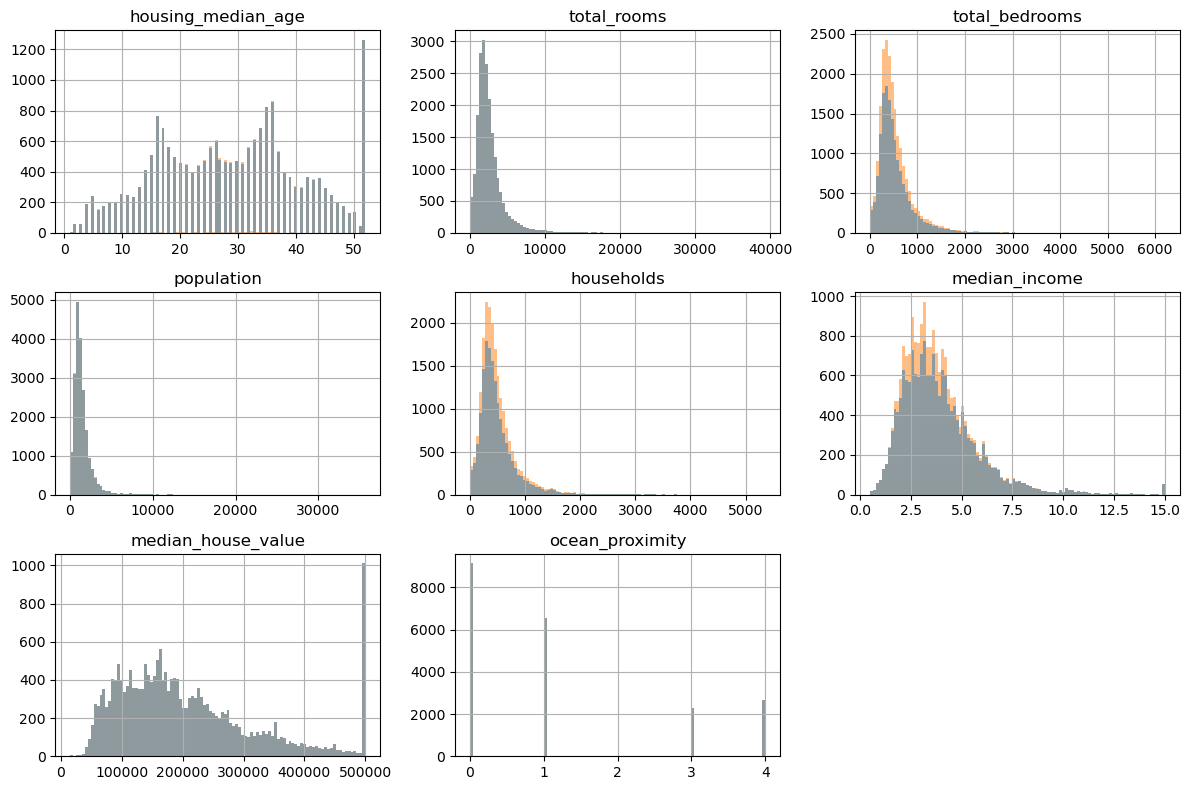

In [249]:
axes = df.iloc[:,2::].hist(bins=100, alpha=0.5, figsize=(12, 8), zorder = 1)
df2.iloc[:,2::].hist(ax=axes.ravel()[:8], bins=100, alpha=0.5, figsize=(12, 8), zorder = 0)
plt.tight_layout()
plt.show()

Observamos en azul la distribución antes de imputar y en naranja despues de imputar. Las distribuciones son muy similares, hay mayor número de frecuencias despues de imputar debido a que ahora se disponen de mayor número de valores.

Nota: En scikit-learn compararon el error MSE obtenido por diferentes métodos de imputacion en los dataset "Diabetes" y "California", encontrándose que el método que imputa con el menor error es justamente "KNN Imputation". 

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

### Tratamiento de outliers

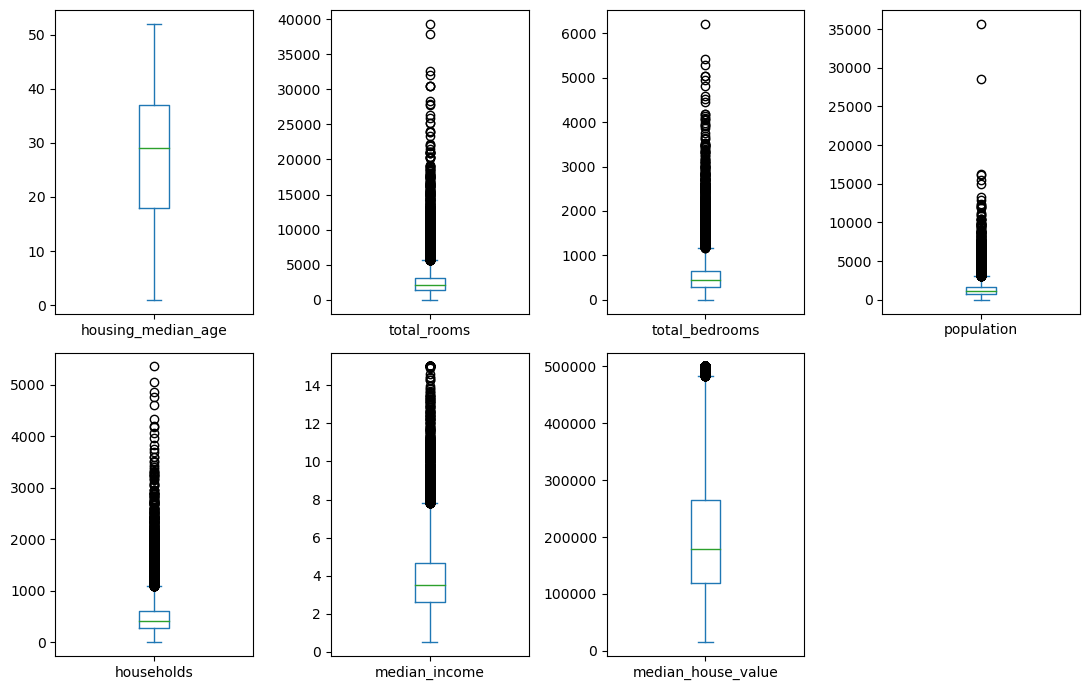

In [250]:
df2.iloc[:,2:-1].plot(kind="box", subplots=True, figsize=(11,7), layout = (2,4))
plt.tight_layout()
plt.show()

Usando gráficos boxplot determinamos visualmente la presencia de outliers. Sin embargo, este método basado en el rango interquartílico sólo es válido en distribuciones normales o, al menos en distribuciones simétricas. No es el caso para distribuciones asímetricas como lo son las distribuciones de Poisson. Podemos ver claramente que el método falla al no detectar posibles outliers a valores bajos de las variables, estando todos a altos valores. 

Por todo esto, la estrategia que se decidió es no eliminar los "outliers", y se buscará privilegiar los algoritmos de aprendizje robustos frente a la presencia de outliers.

## Curación de datos

A los fines de obtener una variable que mejor represente la distancia al mar, se hace uso de la libreria Geopandas. Con ella se importa un archivo shapefile, que se utiliza para almacenar la ubicación geométrica y la información de atributos de las entidades geográficas. Las entidades geográficas de un shapefile se pueden representar por medio de puntos, líneas o polígonos (áreas). En este caso se importó un shapefile de la linea de costa de todo el mundo con una resolución de 110 metros. 

In [251]:
coastal_shapefile_path = "ne_110m_coastline/ne_110m_coastline.shp"
coastal_data = gpd.read_file(coastal_shapefile_path)

Mediante un loop for se calculan las distancias entre los pares longitud - latitud del dataframe a todos los puntos del polígono shapefile, y luego encuentra la mínima de esas distancias. Esas distancias están expresadas en grados, de allí el warning informado por Geopandas. Se convierten esos grados a kilometros de forma muy aproximada al multiplicar por 111.0445, a 38° latitud (Stockton, California) un grado equivale aproximadamente a 69 millas. De esta manera se definió la variable "distance_coast".

https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps

In [252]:
df2['distance_coast'] = None

for index, row in df2.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    
    point = Point(longitude, latitude)
    distances = coastal_data.distance(point) # Calculamos la distancia a todos los puntos de la costa
    distances_min = distances.min() # Encontramos el mínimo valor de distancia

    df2.at[index, 'distance_coast'] = distances_min * 111.0445 

C:\Users\mauri\AppData\Local\Temp\ipykernel_12028\22876490.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = coastal_data.distance(point) # Calculamos la distancia a todos los puntos de la costa


In [370]:
df2['distance_coast'] = df2['distance_coast'].astype('float64')

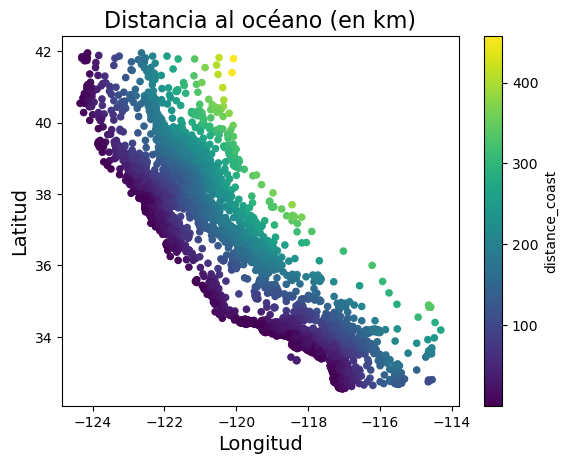

In [258]:
df2.plot(x="longitude", y="latitude", c ="distance_coast", kind="scatter", colormap="viridis")
plt.xlabel('Longitud', fontsize = 14)
plt.ylabel('Latitud', fontsize = 14)
plt.title('Distancia al océano (en km)', fontsize = 16)
plt.show()

Mediante el gráfico anterior se puede apreciar la mínima distancia al océano para cada BG.

De forma similar, se definen otras cinco variables, las cuales serán la distancia de cada BG a las cinco ciudades principales de California (por cantidad de habitantes): Los Ángeles, San Diego, San José, San Francisco y Fresno. Para ello se buscaron las coordenadas de cada una de esas ciudades:

In [287]:
los_angeles = [34.1141, -118.4068] # Longitud y latitud
san_diego = [32.8313, -117.1222]
san_jose = [37.3012, -121.848]
san_francisco = [37.7558, -122.4449]
fresno = [36.783, -119.7939]

cities = [los_angeles, san_diego, san_jose, san_francisco, fresno]
names = ['los_angeles', 'san_diego', 'san_jose', 'san_francisco', 'fresno']

In [372]:
for i in range(len(cities)):
    
    df2[f'distance_{names[i]}'] = None

    for index, row in df.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        
        point1 = Point(cities[i][1], cities[i][0])
        point2 = Point(longitude, latitude)
        
        distance = point1.distance(point2)
        
        df2.at[index, f'distance_{names[i]}'] = distance * 111.0445 
        
    df2[f'distance_{names[i]}'] = df2[f'distance_{names[i]}'].astype('float64')

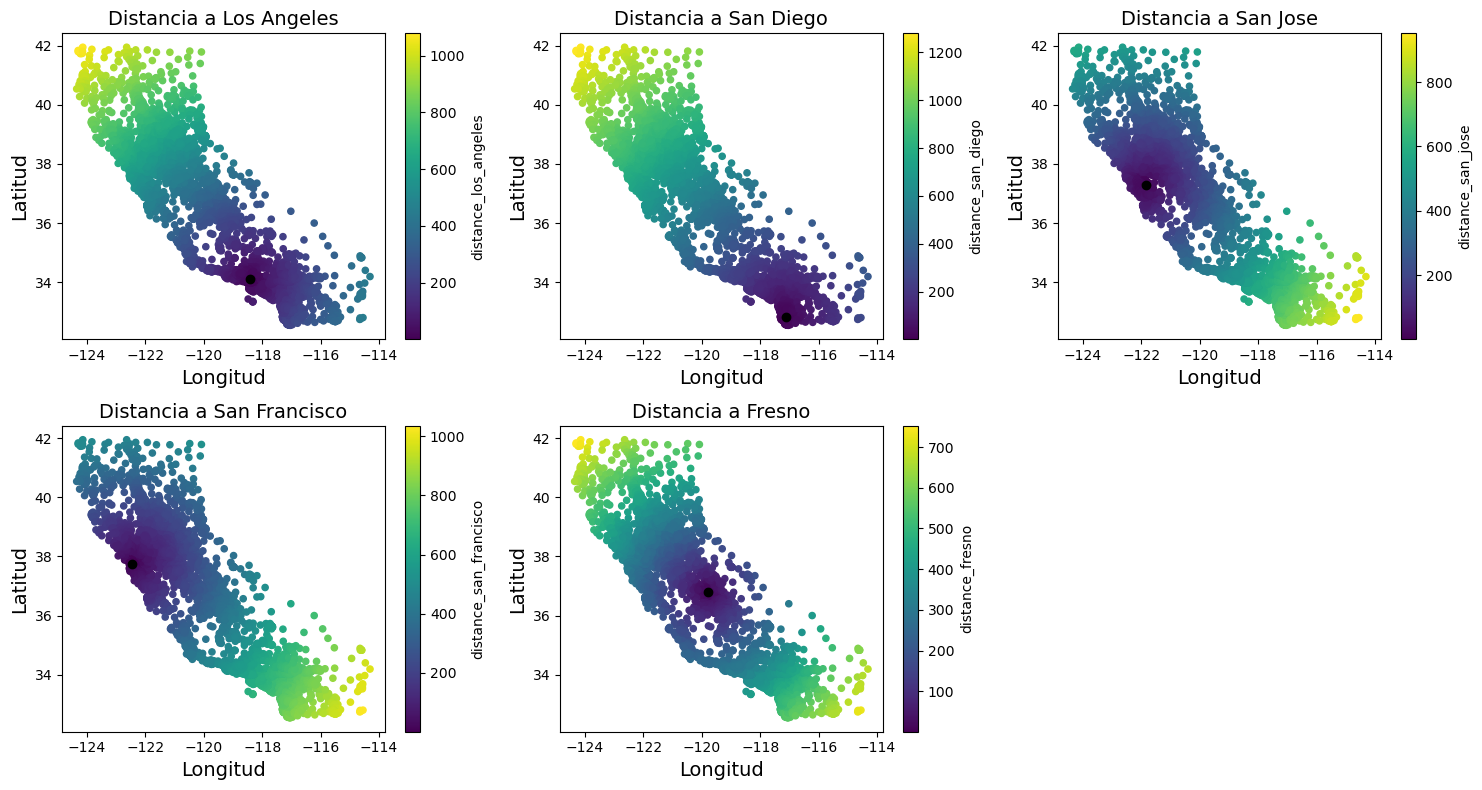

In [357]:
names2 = ['Los Angeles', 'San Diego', 'San Jose', 'San Francisco', 'Fresno']

fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs = axs.ravel()

for i in range(len(cities)):
    df2.plot(x="longitude", y="latitude", c =f'distance_{names[i]}', kind="scatter", colormap="viridis", ax=axs[i])
    axs[i].plot(cities[i][1], cities[i][0], 'o', c = 'k')
    
    axs[i].set_xlabel('Longitud', fontsize = 14)
    axs[i].set_ylabel('Latitud', fontsize = 14)
    
    axs[i].set_title(f'Distancia a {names2[i]}', fontsize = 14)

fig.delaxes(axs[5])

plt.tight_layout()
plt.show()

De nuevo, podemos visualizar las distancias de cada BG a cada centro urbano.

Con estas nuevas variables, descartamos la variable "ocean_proximity".

In [358]:
df2.drop(['ocean_proximity'], axis=1, inplace=True)

In [365]:
df2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,distance_coast,distance_los_angeles,distance_san_diego,distance_san_jose,distance_san_francisco,distance_fresno
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,33.101595,595.915538,797.505121,77.008655,27.562231,296.677826
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,33.522681,593.566467,795.154522,74.543987,27.524178,294.757584
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,31.096864,594.37725,795.95925,74.890887,25.042357,296.343095
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,30.019462,595.172986,796.752471,75.541725,24.037903,297.361252
4,-122.25,37.85,34.0,1627.0,280.0,723.4,259.0,3.8462,342200.0,30.019462,595.172986,796.752471,75.541725,24.037903,297.361252


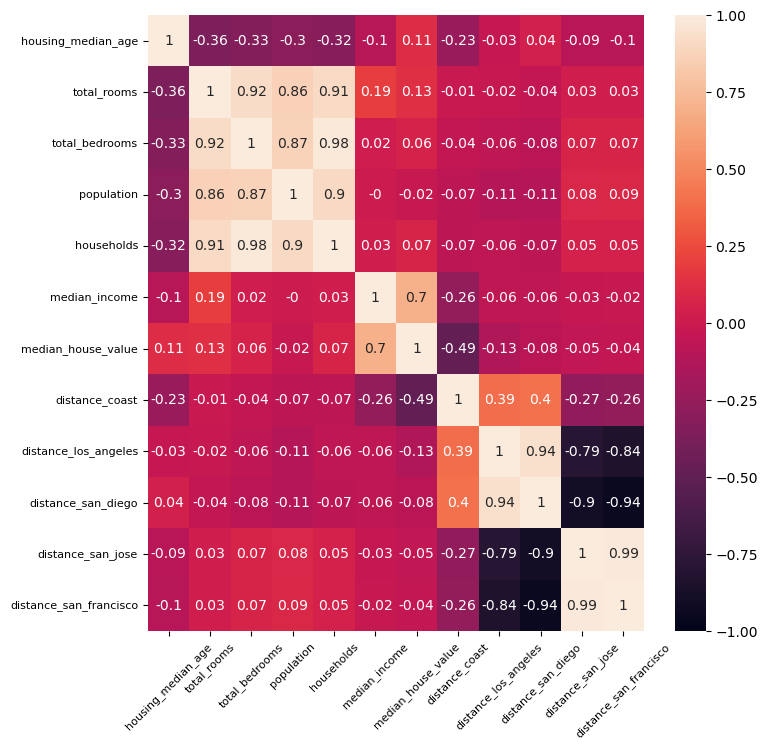

In [377]:
plt.figure(figsize=(8,8))
sns.heatmap(df2.iloc[:,2:-1].corr(numeric_only = True).round(2), vmin=-1, vmax=1, cbar = True, annot=True)
plt.xticks(fontsize = 8, rotation=45) 
plt.yticks(fontsize = 8) 
plt.show()

## Preprocesado

### Escalado de las variables

In [386]:
df3 = df2.copy()

In [396]:
pt = PowerTransformer()
df4 = pd.DataFrame(pt.fit_transform(df3), columns = df3.columns)

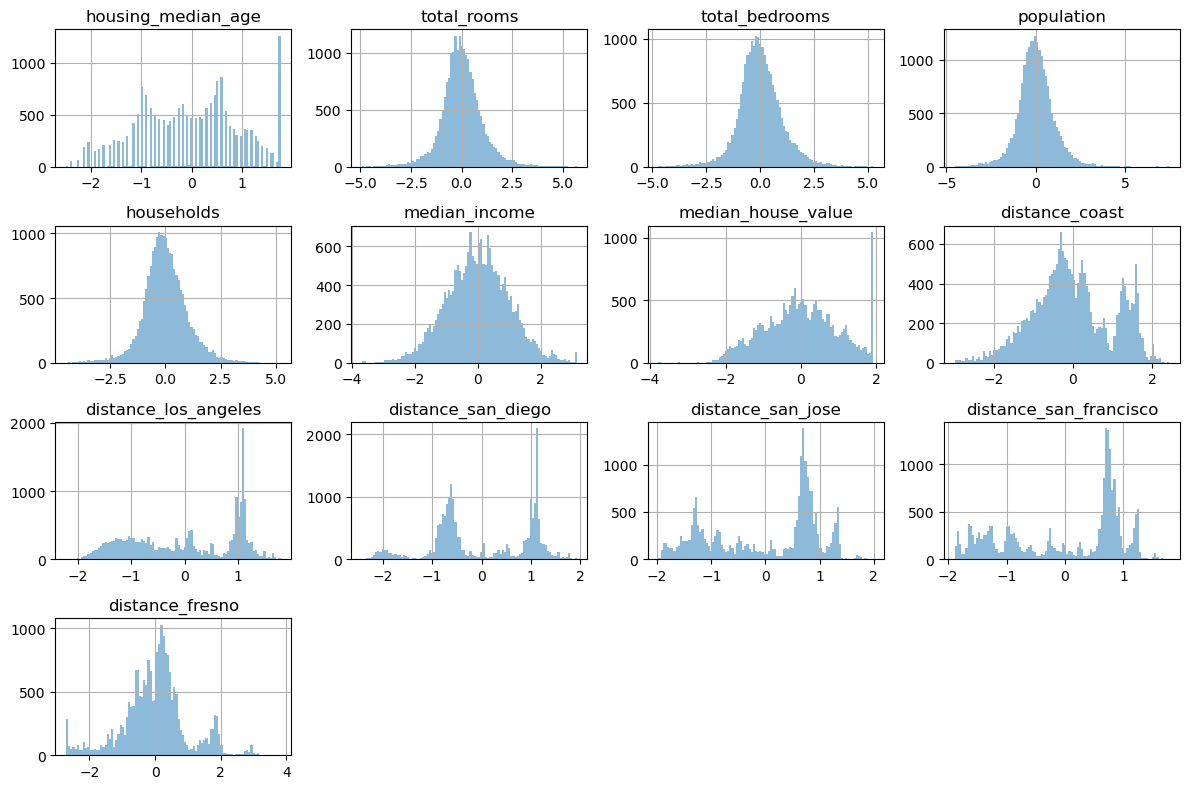

In [400]:
df4.iloc[:,2::].hist(bins=100, alpha=0.5, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Reducción de la dimensionalidad

Se evaluó cuales son las variables que más peso poseen en el dataset, para ello se utilizar el algoritmo Sequential Feature Selector junto al regresor Huber.

In [444]:
X = df4.drop(['median_house_value'], axis = 1) 
y = df4['median_house_value']

print(X.columns.size)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

14


Se utilizó el algoritmo HuberRegressor para realizar el proceso de Feature Selection. Se seleccionó 3, 5, 7, 9, 11 y 13 variables en cada caso, la cual se denominan Sprint 3, Sprint 5, ..., y Sprint 13. Se aplicó sólo la dirección "forward".

In [445]:
from sklearn.linear_model import HuberRegressor

In [446]:
huber = HuberRegressor()

forw = {}

for i in [3, 5, 7, 9, 11, 13]:
    forw[f'sfs_{i}'] = SequentialFeatureSelector(huber, n_features_to_select = i)
    forw[f'sfs_{i}'].fit(X, y)
    print(f'Las {i} variables seleccionadas son: \n', list(X.columns[forw[f'sfs_{i}'].get_support()]))
    forw[f'sfs_{i}_var'] = X.columns[forw[f'sfs_{i}'].get_support()]

Las 3 variables seleccionadas son: 
 ['median_income', 'distance_coast', 'distance_san_jose']
Las 5 variables seleccionadas son: 
 ['median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 7 variables seleccionadas son: 
 ['total_bedrooms', 'population', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 9 variables seleccionadas son: 
 ['longitude', 'total_bedrooms', 'population', 'households', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 11 variables seleccionadas son: 
 ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 13 variables seleccionadas son: 
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'distance

### Huber con Forward Feature Selector

A continuación, se utilizaron modelos de HuberRegressor usando las variables seleccionada en cada caso y se evaluarán las métricas.

In [447]:
huber = HuberRegressor()

MAE, MSE, r2 = [], [], []

for i in [3, 5, 7, 9, 11, 13]:
    X_i = X[list(X.columns[forw[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    huber.fit(X_train, y_train)
    y_pred = huber.predict(X_test)
    
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

In [448]:
Model = [f'Sprint {2*i+1}' for i in range(1,7)]
comparacion_forw = pd.DataFrame({'Modelo': Model, 'MAE': MAE, 'MSE': MSE, 'R2': r2})
comparacion_forw.round(2)

,Modelo,MAE,MSE,R2
0,Sprint 3,0.44,0.34,0.67
1,Sprint 5,0.40,0.29,0.71
2,Sprint 7,0.38,0.26,0.74
3,Sprint 9,0.38,0.26,0.74
4,Sprint 11,0.38,0.26,0.74
5,Sprint 13,0.37,0.26,0.75


Se elige el Sprint 7 para evaluar los diferentes modelos puesto que posee las mejores métricas manteniendo el modelo relativamente sencillo.

## Selección de modelos

A continuación se probarán distintos modelos de regresión y se evaluarán las métricas obtenidas. Como se mencionó al momento de decidir sin incluir o no outliers, se optó por usar algoritmos robustos. Sin embargo tambien se incluye el modelo LinearRegression por ser la puerta de entrada a los modelos de regresion. 

Los algoritmos empleados son Linear, Ridge, Huber, RANSAC y XGBoost.

Se utilizó la lista de siete variables ('total_bedrooms', 'population', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose' y 'distance_fresno') seleccionadas por el Forward Feature Selector utilizando Huber para todos los modelos.

In [455]:
X_7 = X[list(X.columns[forw[f'sfs_{7}'].get_support()])]
X_train, X_test, y_train, y_test = train_test_split(X_7, y, random_state = 42)

### Linear

In [449]:
from sklearn.linear_model import LinearRegression

In [461]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

MAE_lr = (mean_absolute_error(y_test, y_pred))
MSE_lr = (mean_squared_error(y_test, y_pred))
r2_lr = r2_score(y_test, y_pred)

print(f'MAE = {round(MAE_lr, 4)} \nMSE = {round(MSE_lr, 4)} \nR2 = {round(r2_lr, 4)}')

MAE = 0.3821 
MSE = 0.2601 
R2 = 0.7418


### Ridge

In [453]:
from sklearn.linear_model import Ridge

In [462]:
rid = Ridge()
rid.fit(X_train,y_train)

y_pred = rid.predict(X_test)

MAE_rid = (mean_absolute_error(y_test, y_pred))
MSE_rid = (mean_squared_error(y_test, y_pred))
r2_rid = r2_score(y_test, y_pred)

print(f'MAE = {round(MAE_rid, 4)} \nMSE = {round(MSE_rid, 4)} \nR2 = {round(r2_rid, 4)}')

MAE = 0.3821 
MSE = 0.2601 
R2 = 0.7418


### Huber

In [463]:
huber = HuberRegressor()
huber.fit(X_train,y_train)

y_pred = huber.predict(X_test)

MAE_huber = (mean_absolute_error(y_test, y_pred))
MSE_huber = (mean_squared_error(y_test, y_pred))
r2_huber = r2_score(y_test, y_pred)

print(f'MAE = {round(MAE_huber, 4)} \nMSE = {round(MSE_huber, 4)} \nR2 = {round(r2_huber, 4)}')

MAE = 0.3812 
MSE = 0.2616 
R2 = 0.7403


### RANSAC

In [416]:
from sklearn.linear_model import RANSACRegressor

In [464]:
ransac = RANSACRegressor()
ransac.fit(X_train,y_train)

y_pred = ransac.predict(X_test)

MAE_ransac = (mean_absolute_error(y_test, y_pred))
MSE_ransac = (mean_squared_error(y_test, y_pred))
r2_ransac = r2_score(y_test, y_pred)

print(f'MAE = {round(MAE_ransac, 4)} \nMSE = {round(MSE_ransac, 4)} \nR2 = {round(r2_ransac, 4)}')

MAE = 0.4134 
MSE = 0.3067 
R2 = 0.6955


### XGBoost

In [438]:
from xgboost import XGBRegressor

In [467]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

MAE_xgb = (mean_absolute_error(y_test, y_pred))
MSE_xgb = (mean_squared_error(y_test, y_pred))
r2_xgb = r2_score(y_test, y_pred)

print(f'MAE = {round(MAE_xgb, 4)} \nMSE = {round(MSE_xgb, 4)} \nR2 = {round(r2_xgb, 4)}')

MAE = 0.2748 
MSE = 0.1543 
R2 = 0.8468


### Comparación de modelos

In [472]:
comparacion = pd.DataFrame({'Modelo': ['Linear', 'Ridge', 'Huber', 'RANSAC', 'XGBoost'], 
                            'MAE': [MAE_lr, MAE_rid, MAE_huber, MAE_ransac, MAE_xgb], 
                            'MSE': [MSE_lr, MSE_rid, MSE_huber, MSE_ransac, MSE_xgb], 
                            'R2': [r2_lr, r2_rid, r2_huber, r2_ransac, r2_xgb]})

comparacion.round(4)

,Modelo,MAE,MSE,R2
0,Linear,0.3821,0.2601,0.7418
1,Ridge,0.3821,0.2601,0.7418
2,Huber,0.3812,0.2616,0.7403
3,RANSAC,0.4134,0.3067,0.6955
4,XGBoost,0.2748,0.1543,0.8468


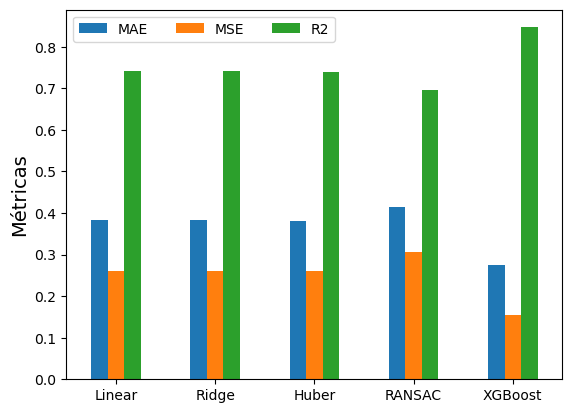

In [481]:
comparacion.plot(x = 'Modelo', kind = 'bar')

plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('Métricas', fontsize = 14)
plt.legend(loc = 'best', ncol = 3)
plt.show()

Se observa en general un buen rendimiento en las métricas obtenidas en cada modelo. Recordemos que no se hizo ajuste fino de los hiperparámetros en ninguno de ellos, por lo que existe amplio margen de mejora. Sin embargo, XGBoost obtuvo métricas sensiblemente superiores, lo que explica la gran popularidad de este modelo.